# CityCam Preprocessing

Please first download the CityCam dataset here: https://www.citycam-cmu.com/

In [2]:
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.imagenet_utils  import preprocess_input, decode_predictions
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Sequential

from PIL import Image

C:\Users\F379071\AppData\Local\Temp\ipykernel_11696\1412818010.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((224, 224), Image.ANTIALIAS)


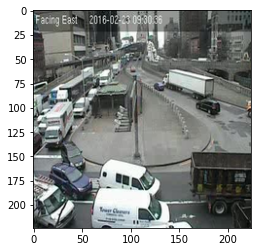

In [7]:
path_to_image = "../datasets/citycam_images/CityCam/164/164-20160223-09/000001.jpg"

image = Image.open(path_to_image)
image = image.resize((224, 224), Image.ANTIALIAS)
plt.imshow(image)

In [5]:
resnet50 = tf.keras.applications.ResNet50(include_top=False, pooling="avg")

In [19]:
error_raised = []

path_to_image_folder = "../datasets/citycam_images/CityCam"
path_to_save_folder = "../datasets/citycam"

for WEBCAM in ["253", "495", "511", "572"]:
    print(WEBCAM)
    if len(WEBCAM) == 3 and os.path.isdir(os.path.join(path_to_image_folder, WEBCAM)):
        for r, d, f in os.walk(path_to_image_folder+"/%s"%WEBCAM):
            for direct in d:

                if not "checkpoint" in direct and not "cache" in d and not "big_bus" in direct:

                    HOUR = direct.split("-")[-1]
                    DAY = direct.split("-")[-2]

                    print(WEBCAM, DAY, HOUR)

                    save_path = path_to_save_folder+"/%s/%s_%s_%s/"%(WEBCAM, WEBCAM, DAY[-3:], HOUR)
                    pathlib.Path(save_path).mkdir(parents=True, exist_ok=True)

                    path = path_to_image_folder+"/%s/%s-%s-%s"%(WEBCAM, WEBCAM, DAY, HOUR)

                    path_to_mask = path + "_msk.png"

                    mask_img = Image.open(path_to_mask)
                    mask = np.array(mask_img)
                    mask_bin = mask[:,:,1]
                    mask_bin = mask_bin % 254

                    x_mask, y_mask = np.where(mask_bin == 1)
                    x_min = x_mask.min()
                    x_max = x_mask.max()+1
                    y_min = y_mask.min()
                    y_max = y_mask.max() + 1                            

                    X = []
                    y = []

                    i = 1
                    no_error = True
                    while no_error:
                        try:
                            img_name = "0" * (6 - len(str(i))) + str(i) + ".jpg"
                            path_to_image = path + "/" + img_name

                            image_img = Image.open(path_to_image)
                            image = np.array(image_img)

                            for j in range(3):
                                image[:,:,j] = image[:,:,j] * mask_bin


                            croped_image = image[x_min:x_max, y_min:y_max]
                            croped_image_img = Image.fromarray(croped_image)
                            croped_image_resize = croped_image_img.resize((224, 224), Image.ANTIALIAS)

                            final_image = np.array(croped_image_resize)

                            output = resnet50.predict(np.array([final_image])).ravel()

                            count = 0

                            xml_name = "0" * (6 - len(str(i))) + str(i) + ".xml"
                            label_path = path + "/" + xml_name

                            file = open(label_path)
                            for line in file:
                                if "<vehicle>" in line:
                                    count += 1

                            X.append(output)
                            y.append(count)

                            print("image %i  -  Count: %i"%(i, count))

                            i += 1

                        except:
                            no_error = False

                    error_raised.append([WEBCAM + "-" + DAY + "-" + HOUR, no_error])

                    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
                    ax.imshow(final_image)
                    plt.show()


                    X = np.array(X)
                    y = np.array(y)


                    try:
                        np.save(save_path + "X.npy", X)
                        np.save(save_path + "y.npy", y)
                    except:
                        raise ValueError("No save path")